### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [4]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [5]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [16]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [17]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [8]:
# 印出網路結構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [14]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')


Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0083 - val_loss: 0.0024

Epoch 00001: val_loss improved from inf to 0.00235, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00235 to 0.00195, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00195 to 0.00190, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00190
Epoch 5/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00190
Epoch 6/150
1712/1712 [==============================] - 5s 3ms/step -

1712/1712 [==============================] - 6s 4ms/step - loss: 1.9671e-04 - val_loss: 8.0555e-04

Epoch 00045: val_loss did not improve from 0.00079
Epoch 46/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.9617e-04 - val_loss: 8.0198e-04

Epoch 00046: val_loss did not improve from 0.00079
Epoch 47/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.9212e-04 - val_loss: 8.2630e-04

Epoch 00047: val_loss did not improve from 0.00079
Epoch 48/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.9259e-04 - val_loss: 8.3620e-04

Epoch 00048: val_loss did not improve from 0.00079
Epoch 49/150
1712/1712 [==============================] - 6s 4ms/step - loss: 1.8898e-04 - val_loss: 7.9616e-04

Epoch 00049: val_loss did not improve from 0.00079
Epoch 50/150
1712/1712 [==============================] - 7s 4ms/step - loss: 1.8258e-04 - val_loss: 7.9206e-04

Epoch 00050: val_loss did not improve from 0.00079
Epoch 51/150
1712/1712 [=====

1712/1712 [==============================] - 6s 4ms/step - loss: 9.0365e-05 - val_loss: 7.9660e-04

Epoch 00143: val_loss did not improve from 0.00075
Epoch 144/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.4140e-05 - val_loss: 7.9595e-04

Epoch 00144: val_loss did not improve from 0.00075
Epoch 145/150
1712/1712 [==============================] - 6s 3ms/step - loss: 8.6661e-05 - val_loss: 8.0100e-04

Epoch 00145: val_loss did not improve from 0.00075
Epoch 146/150
1712/1712 [==============================] - 6s 3ms/step - loss: 8.9331e-05 - val_loss: 7.5537e-04

Epoch 00146: val_loss did not improve from 0.00075
Epoch 147/150
1712/1712 [==============================] - 6s 3ms/step - loss: 8.8685e-05 - val_loss: 7.8597e-04

Epoch 00147: val_loss did not improve from 0.00075
Epoch 148/150
1712/1712 [==============================] - 6s 3ms/step - loss: 8.6644e-05 - val_loss: 7.8303e-04

Epoch 00148: val_loss did not improve from 0.00075
Epoch 149/150
1712/1712 

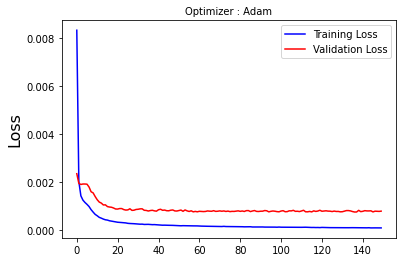

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [12]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [7]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        plt.text((points[i] + 0.5)*96, (points[i+1]+0.5-0.05)*96, str(int(i/2))) # 把關鍵點 index 畫出來

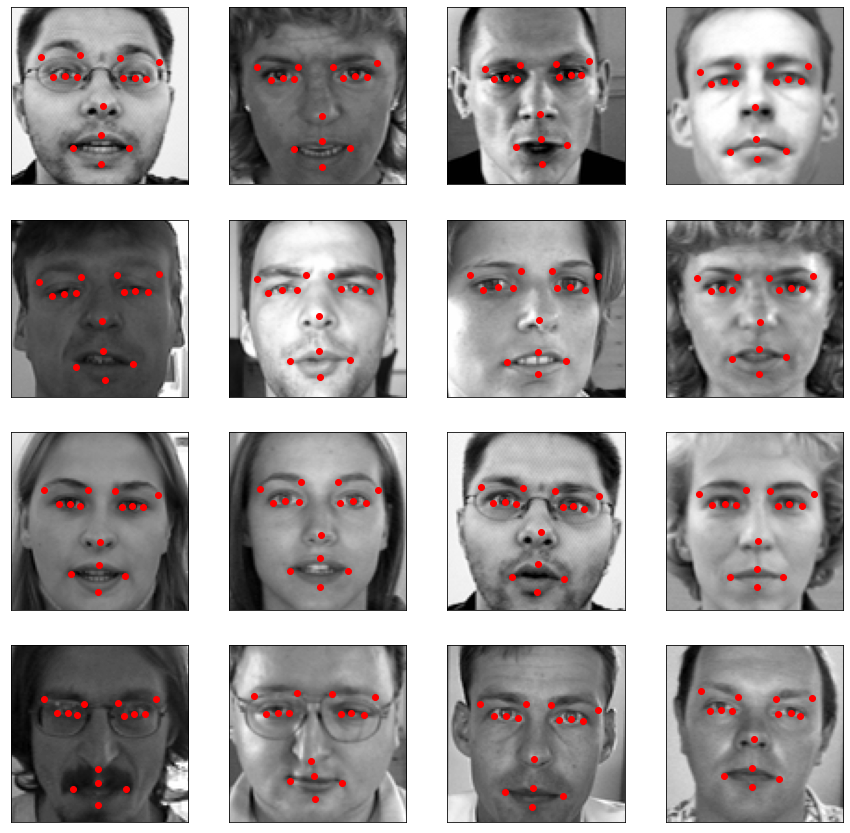

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [8]:
def flip_data(img, points):
    rows, cols = img.shape
#     print("rows:", rows)
#     print("cols:", cols)
    new_img = np.copy(img)
    
    for i in range(rows):
        for j in range(cols//2):
            tmp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = tmp

    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
        
    new_points_withoutarrange = np.copy(new_points)
#     print("Without arrange: \n", new_points_withoutarrange)
    
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
    
#     print("With arrange: \n", new_points)
        
    return new_img, new_points, new_points_withoutarrange

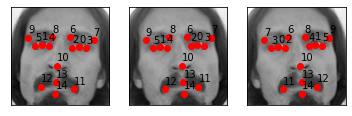

In [11]:
flip_img, flip_points, flip_poins_withoutarrange = flip_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_poins_withoutarrange) # 翻轉後的圖片

In [12]:
aug_imgs_train = []
aug_points_train = []

for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point_witharrange, aug_point = flip_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [18]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment_20201028.h5', verbose=1, save_best_only=True)

# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('best_weights_augment_20201028.h5')
# save the model
model.save('best_weights_augment_20201028.h5')


Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0055 - val_loss: 0.0020

Epoch 00001: val_loss improved from inf to 0.00195, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0015 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00195 to 0.00187, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0018

Epoch 00003: val_loss improved from 0.00187 to 0.00184, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00184
Epoch 5/150
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0011 - val_loss: 0.0018

Epoch 00005: val_loss improved from 0.00184 to 0.00178, saving model to best_weights.h5
Epoch 6/150
1712/1712 [==========

1712/1712 [==============================] - 6s 3ms/step - loss: 1.9472e-04 - val_loss: 7.5511e-04

Epoch 00044: val_loss did not improve from 0.00072
Epoch 45/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.9123e-04 - val_loss: 7.5519e-04

Epoch 00045: val_loss did not improve from 0.00072
Epoch 46/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.9142e-04 - val_loss: 8.0645e-04

Epoch 00046: val_loss did not improve from 0.00072
Epoch 47/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.9050e-04 - val_loss: 8.0273e-04

Epoch 00047: val_loss did not improve from 0.00072
Epoch 48/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.8157e-04 - val_loss: 7.4132e-04

Epoch 00048: val_loss did not improve from 0.00072
Epoch 49/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.8287e-04 - val_loss: 7.4307e-04

Epoch 00049: val_loss did not improve from 0.00072
Epoch 50/150
1712/1712 [=====


Epoch 00093: val_loss did not improve from 0.00071
Epoch 94/150
1712/1712 [==============================] - 5s 3ms/step - loss: 1.2222e-04 - val_loss: 7.5770e-04

Epoch 00094: val_loss did not improve from 0.00071
Epoch 95/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.1938e-04 - val_loss: 7.5734e-04

Epoch 00095: val_loss did not improve from 0.00071
Epoch 96/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.1752e-04 - val_loss: 7.3232e-04

Epoch 00096: val_loss did not improve from 0.00071
Epoch 97/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.1775e-04 - val_loss: 7.1739e-04

Epoch 00097: val_loss did not improve from 0.00071
Epoch 98/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.1898e-04 - val_loss: 7.2637e-04

Epoch 00098: val_loss did not improve from 0.00071
Epoch 99/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.1389e-04 - val_loss: 7.2579e-04

Epoch 00099: va

1712/1712 [==============================] - 6s 3ms/step - loss: 8.5869e-05 - val_loss: 7.4262e-04

Epoch 00143: val_loss did not improve from 0.00071
Epoch 144/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.0228e-05 - val_loss: 7.4289e-04

Epoch 00144: val_loss did not improve from 0.00071
Epoch 145/150
1712/1712 [==============================] - 6s 3ms/step - loss: 8.5573e-05 - val_loss: 7.6330e-04

Epoch 00145: val_loss did not improve from 0.00071
Epoch 146/150
1712/1712 [==============================] - 6s 3ms/step - loss: 8.6187e-05 - val_loss: 7.7355e-04

Epoch 00146: val_loss did not improve from 0.00071
Epoch 147/150
1712/1712 [==============================] - 7s 4ms/step - loss: 8.5288e-05 - val_loss: 7.7107e-04

Epoch 00147: val_loss did not improve from 0.00071
Epoch 148/150
1712/1712 [==============================] - 6s 4ms/step - loss: 8.5301e-05 - val_loss: 7.6748e-04

Epoch 00148: val_loss did not improve from 0.00071
Epoch 149/150
1712/1712 

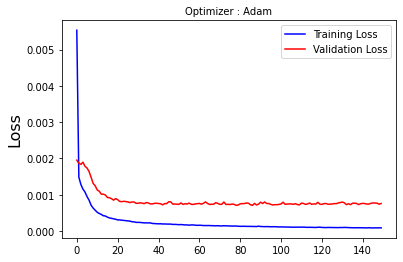

In [19]:
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')